# py4DSTEM Tutorial - Differential Phase Contrast Reconstruction
---

### Introduction

This is a tutorial notebook intended to teach you how to use py4DSTEM to perform a differential phase contrast (DPC) reconstruction from a 4D-STEM dataset. The steps we will perform are:

* [Part 0 - Download and load the 4D-STEM dataset.](#part_00)
* [Part 1 - Calculate the center-of-mass (CoM) for each probe position.](#part_01)
* [Part 2 - Determine the relative rotation between the scan direction and the diffraction space images.](#part_02)
* [Part 3 - Reconstruct the differential phase contrast (DPC) signal.](#part_03)

A deep knowledge of the theory of DPC imaging is not required for this tutorial. All you need to know is that (given some assumptions) when a STEM probe passes through a sample potential, the STEM probe will deflect in the direction of the gradient of this potential. In a far field (diffraction space) measurement, we can directly measure the average momentum change of a STEM probe as a 2-element vector by taking the CoM of the electron counts. We repeat this process for all STEM probe positions. To reconstruct the sample's potential, we simply need to invert this 2D gradient measurement.

For more information on the history and theory of DPC, and the algorithm used in py4DSTEM, see the following references:
* N Dekkers & H De Lang, [Differential phase contrast in a STEM](http://xrm.phys.northwestern.edu/research/pdf_papers/1974/dekkers_optik_1974.pdf), Optik 41, 452–456 (1974).
* A Lubk & J Zweck. [Differential phase contrast: An integral perspective](https://doi.org/10.1103/PhysRevA.91.023805), Phys Rev A 91, 023805 (2015).
* B Savitzky et al., [py4DSTEM: A Software Package for Four-Dimensional Scanning Transmission Electron Microscopy Data Analysis](https://doi.org/10.1017/S1431927621000477), Microscopy and Microanalysis (2021).

### Acknowledgements

This tutorial was written by Colin Ophus at Berkeley Lab (clophus@lbl.gov).

The 4D-STEM dataset used in this tutorial was provided by David Muller, from this reference
[TODO - add reference]


### Version
Last updated on 2021-06-01 with py4DSTEM version 0.12.3

---
# Part 0 - Download the datasets used in this tutorial <a class="anchor" id="part_00"></a>

You can download the tutorial dataset here: (50 megabytes)
* [MoS2 EMPAD dataset](https://drive.google.com/file/d/1A3cNF5s5rPFIQDwnSMuCBiTEWNNf0Lcp/view?usp=sharing)

In [1]:
# Initialization - import the needed packages.
# For thidownload_file_from_google_driveill need py4DSTEM, numpy
import py4DSTEM
import numpy as np
import scipy.io

If you are running in **binder** run the cell below, otherwise skip.

In [ ]:
from py4DSTEM.io import download_file_from_google_drive
download_file_from_google_drive("1bHv3u61Cr-y_GkdWHrJGh1lw2VKmt3UM", "/home/jovyan/data/MoS2_4D_data_step2x_crop_3x3uc.mat")

Once you have downloaded this data, update the variable `file_path_input` in the next cell to reflect that path to the file on your computer.

In [2]:
# Set the file paths for the input datasets.
# The location of these files may be different, depending on your operating system and browser download path.
# If you are running this tutorial on Binder, you do not need to change this path.
file_path_input = '/media/cophus/DATA/4DSTEM/MoS2_4D_data_step2x_crop_3x3uc.mat'
# file_path_input = 'C:/data/MoS2_4D_data_step2x_crop_3x3uc.mat'

In [3]:
# This dataset is stored in a Matlab .mat file, which we can load with scipy
mat = scipy.io.loadmat(file_path_input)

In [4]:
# This .mat file contains multiple arrays, but the one we want is named 'dp' and can be accessed like so
stack4D = mat['dp']

In [5]:
# Check the size of this 4D array
stack4D.shape

(124, 124, 31, 26)

In [6]:
# py4DSTEM expects the real space dimensions, followed by the diffraction space dimensions.  
# We therefore will transpose the data before converting to a py4DSTEM datacube:
dataset = py4DSTEM.io.DataCube(data=np.transpose(stack4D,(3,2,1,0)))

In [7]:
# To verify that we have reversed the ordering, we can again check the shape of the array
dataset.data.shape

(26, 31, 124, 124)

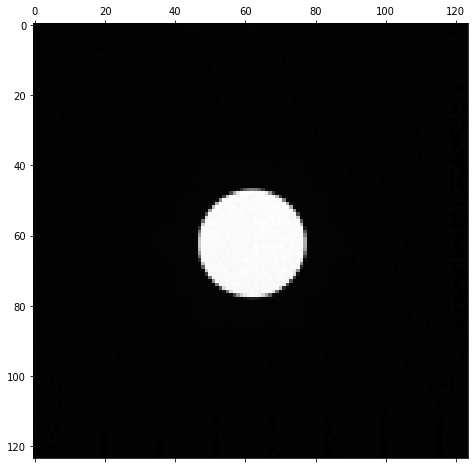

In [8]:
# Let's examine the mean diffraction space image, by taking the average over all probe positions:
diffraction_pattern_mean = np.mean(dataset.data, axis=(0,1))
py4DSTEM.visualize.show(diffraction_pattern_mean)

In the mean diffraction pattern image, we can clearly see the initial STEM probe. For a thin specimen, most of the electrons will remain inside the bright field (BF) disk, i.e. the angular range of the initial STEM beam). This means that changing the TEM camera length or cropping the dataset around the BF disk is reasonable for a DPC reconstruction, though we will get better* results if we use as many electrons as possible.

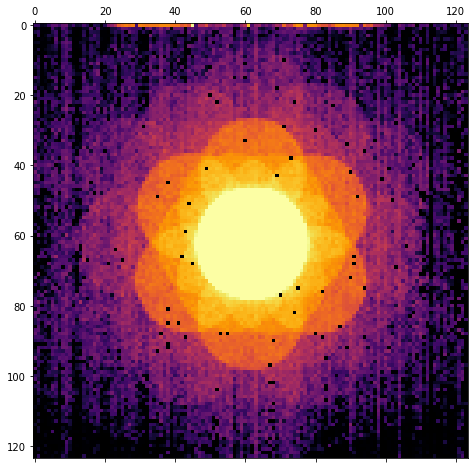

In [9]:
# We will now plot the mean diffraction image using different scaling, in order to see both bright and dim features:
py4DSTEM.visualize.show(
    diffraction_pattern_mean,
    scaling='log',   
    clipvals='manual',
    min=1e0,
    max=1e2,
    cmap='inferno')

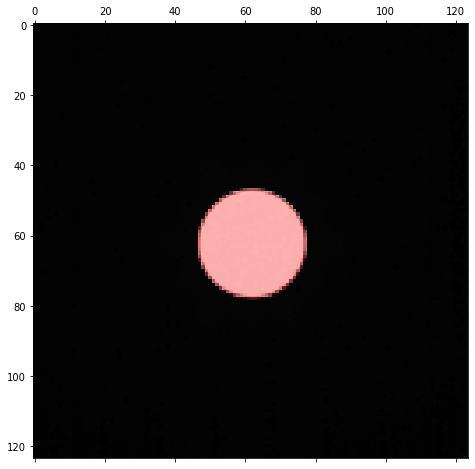

Estimated probe radius = 15.30 pixels


In [10]:
# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, qx0, qy0 = py4DSTEM.process.calibration.get_probe_size(diffraction_pattern_mean)

# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
py4DSTEM.visualize.show_circles(diffraction_pattern_mean, (qx0, qy0), probe_semiangle)

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')

By overlaying a circle, we can see a common artifact in STEM simulations: ellipticity of either the original probe aperture, or the projecter system of the TEM. This ellipticity will not affect our DPC measurement, although we should be careful to use a large enough virtual detector / cropping range to fully capture the BF signal for all probe positions.

100%|██████████████████████████████████████████████████████████████████████████████| 806/806 [00:00<00:00, 32464.96it/s]


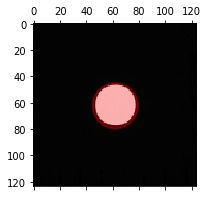

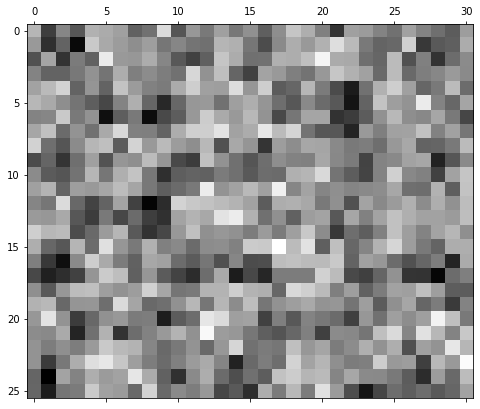

In [11]:
# Next, create a bright field (BF) virtual detector using the the center beam position, and expanding the radius slightly (+ 2 px).
expand_BF = 2.0
image_BF = py4DSTEM.process.virtualimage.get_virtualimage_circ(dataset, qx0, qy0, probe_semiangle + expand_BF)

# Show the BF image, next to the virtual detector we have used
py4DSTEM.visualize.show_circles(diffraction_pattern_mean, (qx0, qy0), probe_semiangle + expand_BF, figsize=(3,3))
py4DSTEM.visualize.show(image_BF)

Virtually no contrast is visible in the virtual BF image - this image contrast roughly corresponds to the `amplitude` of the sample's exit wave. In the following sections, we will use CoM-DPC to measute the `phase`, which will hopefully produce significantly more signal in the image.

---
# Part 1 - Calculate the center-of-mass (CoM) for each probe position. <a class="anchor" id="part_01"></a>

In this section, we will compute the (qx_shift, qy_shift) momentum vector estimate for all probe positions. We accomplish this by computing the first moment of the intentisty distribution in the x and y directions.

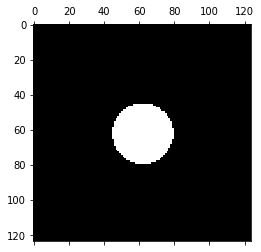

In [12]:
# Generate the circular mask, using the same coordinates determined above.
mask = py4DSTEM.process.utils.make_circular_mask(shape = (dataset.Q_Nx,dataset.Q_Ny),
                                               qxy0 = (qx0, qy0),
                                               radius = probe_semiangle + expand_BF)
    
# Plot the mask
py4DSTEM.visualize.show(mask, figsize=(4,4))

In [13]:
# Calculate the center of mass for all probe positions
CoMx, CoMy = py4DSTEM.process.dpc.get_CoM_images(dataset, mask=mask)

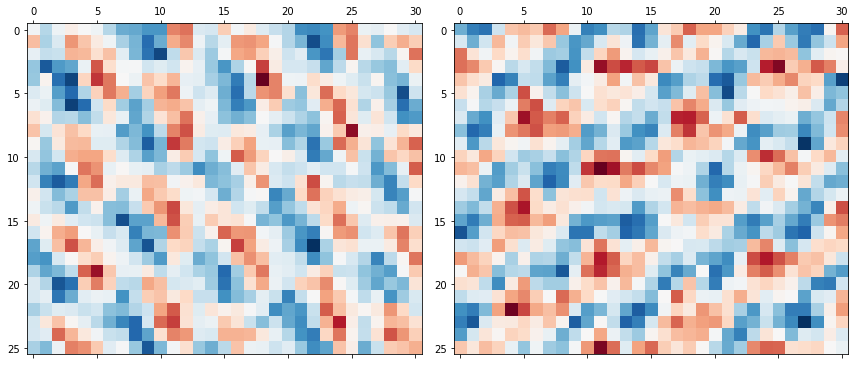

In [14]:
# Plot the 2 CoM outputs, the x and y directions
py4DSTEM.visualize.show_image_grid(
    lambda i:[CoMx, CoMy][i],
    H=1,
    W=2,
    cmap='RdBu')

These images are significantly clearer than the virtual BF image!  

Ideally, CoMx measures the beam deflection in the vertical direction.  As the probe scans downwards, we expect it to deflect in the positive direction (red) as it hits the edge of the sample, and then in the negative direction (blue as it leaves the sample). This is what we observe in the left plot. Similarly, the CoMy signal should show a positive and then negative deflection, as it scans from the left hand edge of the field of view to the right. This is also what we see in the above right side image. 

Therefore, it's likely that the scan directions of this experiment are properly aligned to the diffraction space image coordinates. We will however check this assumption in the next section. We will plot one more output first, the total gradient magnitude sqrt(CoMx^2 + CoMy^2), which is equal to the magnitude of the electric field at each probe position.

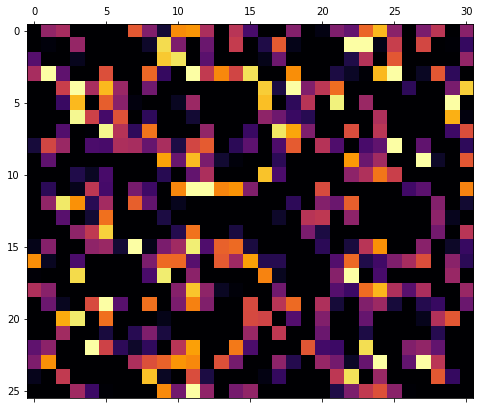

In [15]:
# Plot the gradient magnitude, from 0 to 2 standard deviations
py4DSTEM.visualize.show(np.sqrt(CoMx**2 + CoMy**2),
                       cmap='inferno',
                       clipvals='std',
                       min=0.0,
                       max=2.0)

---
# Part 2 - Determine the rotation between real and diffraction space. <a class="anchor" id="part_02"></a>

Here, we will check to see if the real space coordinate directions (x,y) matches the diffraction space coordinate directions (qx, qy).  

There are a few methods to perform this check in py4DSTEM.  We will simply test all rotation angles (and all rotation angles for a flipped dataset), and then select whichever angle produces the highest contrast.  Alternative methods include solving for the direction which sets the vector field curl as close to zero as possible, or a gradient search.

In [16]:
# Use one of the py4DSTEM algorithms to check for:
# 1 - rotation offset between real and diffraction space coordinates
# 2 - a flip / transpose of the two spaces
theta, flip =  py4DSTEM.process.dpc.get_rotation_and_flip_maxcontrast(CoMx, CoMy, 360)

Analyzing: |**************************************************| 100.0% Complete.



In [17]:
# Solve for minimum rotation from (-pi,pi) radian range
theta = np.mod(theta + np.pi, 2*np.pi) - np.pi
theta_deg = theta*180/np.pi

# Print the results
print('Image flip detected =', flip);
print('Best fit rotation = ', '%.4f' % theta_deg, 'degrees')

Image flip detected = True
Best fit rotation =  -61.1699 degrees


As we see, this routine thinks the data is flipped (or transposed), and the best fit rotation is -61 degrees. Using these 2 pieces of information, we can proceed with the phase reconstruction. Note that the flip / transpose could be due to the np.tranpose call we used earlier. We could remove this flip by changing it to read:
> dataset = py4DSTEM.io.DataCube(data=np.transpose(stack4D,(2,3,0,1)))

This line will swap (x,y) with (kx,ky), but leave the order of each pair alone.

---
# Part 3 - Reconstruct the phase contrast signal. <a class="anchor" id="part_03"></a>

The final step is to invert the above gradient measurements into the underlying scalar field, the phase shift or potential of the sample.

### Our phase reconstruction method

The CoM DPC signal measures the gradient of the sample's potential. If we had the potential, we could differentiate it numerically to obtain this gradient. We want to go the other direction however. We could in principle write down the series of linear equations for the center-difference numerical gradient operator, and solve for all of the pixels by inverting this sparse matrix (with some assumptions at the boundaries).  However constructing this matrix is tedious, and it's fairly unstable without regularzation. 

Fortunately, there is a better way! As in most microscopy data analysis problems, we will use Fourier transforms. Essentially, we will compute the "inverse gradient" to reconstruct the DPC phase signal.  For more information, see:
>B Savitzky et al., [py4DSTEM: A Software Package for Four-Dimensional Scanning Transmission Electron Microscopy Data Analysis](https://doi.org/10.1017/S1431927621000477), Microscopy and Microanalysis (2021).

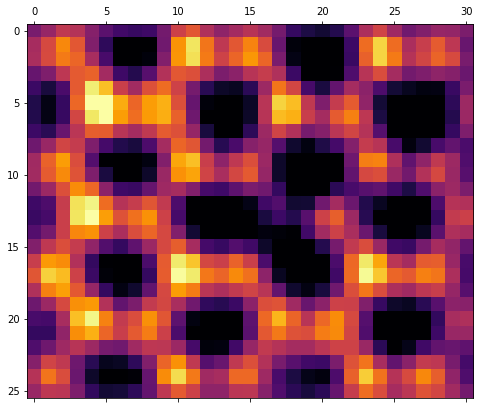

In [18]:
# Input parameters
regLowPass = 0.0
regHighPass = 0.0
theta_recon = theta  # We get the same reconstruction with 0 rotation - try it!
flip_recon = flip   # We just set this to True
paddingfactor = 2    # This parameter handles the boundary conditions via padding the reconstruction space
stepsize = 1         # Step size for each iteration
n_iter = 8         # Number of iterations

# Reconstruct the phase
phase, error = py4DSTEM.process.dpc.get_phase_from_CoM(
    CoMx, 
    CoMy, 
    theta=theta_recon, 
    flip=True,
    regLowPass=regLowPass, 
    regHighPass=regHighPass, 
    paddingfactor=paddingfactor,
    stepsize=stepsize, 
    n_iter=n_iter)

# Plot the output phase image
py4DSTEM.visualize.show(phase,
                       cmap='inferno',
                       clipvals='manual',
                       min=-3,
                       max=6)

The MoS2 lattice image looks very good!  Clean atomic sites are visible for all positions.

Because this dataset has a very low sampling rate, we may want to upsample it for display purposes.  To increase the sampling resolution for a signal without modifying the information contained in it, we can use Fourier interpolation.

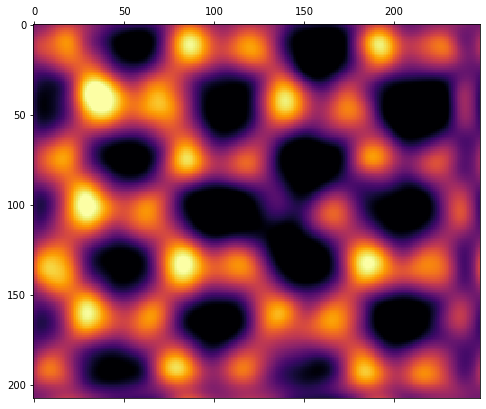

In [19]:
# Use Fourier interpolation to upsample the reconstructed phase image.
# phase_upsample = py4DSTEM.process.utils.fourier_resample(phase, output_size=(400, 500))
phase_upsample = py4DSTEM.process.utils.fourier_resample(phase, scale=8)

# plot the upsampled image
py4DSTEM.visualize.show(phase_upsample,
                       cmap='inferno',
                       clipvals='manual',
                       min=-3,
                       max=6)

Finally, we will examine regularization of the reconstruction.

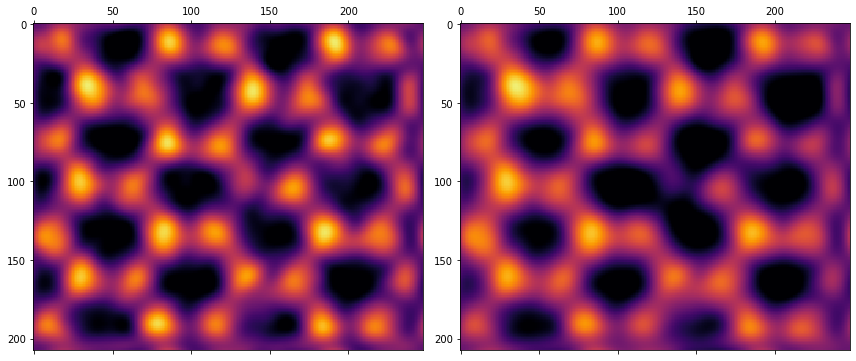

In [20]:
# Input parameters with slight regularization
regLowPass = 0
regHighPass = 0.01
theta_recon = theta  # We get the same reconstruction with 0 rotation - try it!
flip_recon = True   # We just set this to False
paddingfactor = 2    # This parameter handles the boundary conditions via padding the reconstruction space
stepsize = 1         # Step size for each iteration
n_iter = 16           # Number of iterations

# Reconstruct the phase
phase_reg, error_ref = py4DSTEM.process.dpc.get_phase_from_CoM(
    CoMx, 
    CoMy, 
    theta=theta_recon, 
    flip=flip_recon,
    regLowPass=regLowPass, 
    regHighPass=regHighPass, 
    paddingfactor=paddingfactor,
    stepsize=stepsize, 
    n_iter=n_iter)


# Upsample to make the differences easier to see
phase_reg_upsample =  py4DSTEM.process.utils.fourier_resample(phase_reg, scale=8)

# plot images
py4DSTEM.visualize.show_image_grid(
    lambda i:[phase_reg_upsample, phase_upsample][i],
    H=1,
    W=2,
    clipvals='std',
    min=-1.5,
    max=3.0,
    cmap='inferno')